In [1]:
import pandas as pd
import warnings
import numpy as np
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import tensorflow as tf
sess = tf.Session()

In [2]:
#taken input
power = pd.read_csv("power.csv")
power.columns = ["Power_time", "Power"]
temp = pd.read_csv("amb_temp.csv")
temp.columns = ["Temp_time", "Temp"]

In [3]:
#simple 2 min resampling
def returnsample(power):
    returnempty = []
    for i in range(0,round(power.shape[0]/120)-1):
        empty = []
        empty = power[i*120+1:i*120+120]
        returnempty.append(np.average(empty))
        
    empty = power[120*(round(power.shape[0]/120)-1):]
    returnempty.append(np.average(empty))
    
    return returnempty

In [4]:
power_data = returnsample(power["Power"].values)
temp_data = returnsample(temp["Temp"].values)

In [5]:
power_data = np.array(power_data)
power_data = power_data.astype(int)

temp_data = np.array(temp_data)
temp_data = temp_data.astype(int)

In [104]:
print(len(power_data))
len(temp_data)

192


192

In [6]:
#creating the whole tensorflow model to get the physical model findings

x_data = tf.placeholder(shape = [1],dtype = tf.float32)
y_target = tf.placeholder(shape = [1], dtype = tf.float32)

A = tf.Variable(tf.random_normal(shape = [1]))
b = tf.Variable(tf.random_normal(shape = [1]))

output = tf.add(tf.multiply(x_data,A),b)
loss = tf.square(output - y_target)

init = tf.global_variables_initializer()
sess.run(init)

my_opt = tf.train.GradientDescentOptimizer(learning_rate = 0.0001)
train_step = my_opt.minimize(loss)

In [24]:
#Getting the best readings 

for i in range(1000):
    index = np.random.choice(60)
    
    x = [temp_data[index]]
    y = [power_data[index]]
    
    sess.run(train_step, feed_dict = {x_data : x, y_target : y})
    print('Step: ', i+1, "A is: ", sess.run(A), " b is: ", sess.run(b))
    print('Loss: ',sess.run(loss, feed_dict = {x_data : x, y_target : y}))

Step:  1 A is:  [ 50.5664978]  b is:  [ 2.93622398]
Loss:  [ 24712.40039062]
Step:  2 A is:  [ 51.43464661]  b is:  [ 2.96837759]
Loss:  [ 18850.23046875]
Step:  3 A is:  [ 49.75387192]  b is:  [ 2.90834999]
Loss:  [ 64017.4609375]
Step:  4 A is:  [ 48.45122528]  b is:  [ 2.85824823]
Loss:  [ 46911.265625]
Step:  5 A is:  [ 46.69600296]  b is:  [ 2.79324007]
Loss:  [ 77053.6171875]
Step:  6 A is:  [ 45.67522812]  b is:  [ 2.75678372]
Loss:  [ 23612.38085938]
Step:  7 A is:  [ 46.27204132]  b is:  [ 2.7806561]
Loss:  [ 10903.18847656]
Step:  8 A is:  [ 51.29301453]  b is:  [ 2.95997643]
Loss:  [ 571287.625]
Step:  9 A is:  [ 51.23800659]  b is:  [ 2.95786071]
Loss:  [ 83.651474]
Step:  10 A is:  [ 50.70846558]  b is:  [ 2.93667912]
Loss:  [ 8583.70996094]
Step:  11 A is:  [ 49.51249313]  b is:  [ 2.89809942]
Loss:  [ 24269.09179688]
Step:  12 A is:  [ 50.57772064]  b is:  [ 2.93755245]
Loss:  [ 28380.11523438]
Step:  13 A is:  [ 55.67010498]  b is:  [ 3.10729861]
Loss:  [ 484123.09375]


In [26]:
# checking variation in the data
print(np.std(power_data))
np.std(temp_data)

318.118898654


2.8965030325736469

In [18]:
len(temp_data)

192

In [25]:
besta = 47.33220673 
bestb = 2.49423003

In [27]:
#here we have calculated the best possible A and b 
#Hence we will predict the power based on these values now, 
# formula is Power = A* Temp + b

In [182]:
train = power_data[0:round(len(power_data)*0.8)]
test = power_data[round(len(power_data)*0.8):]

In [183]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

pred = results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()

In [184]:
predicted = pred_ci["lower y"] + pred_ci["upper y"]
predicted = predicted/2

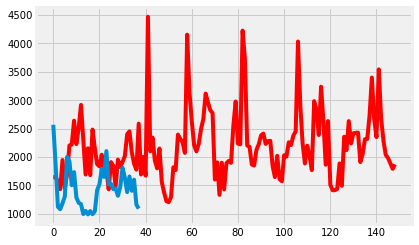

In [221]:

plt.plot(new_predicted, color = "red")
#plt.plot(predicted, color= "green")
plt.plot(test)
plt.show()

In [186]:
#we have the H and L to compare now
alpha = 0.998
H = np.percentile(predicted,alpha)
L = np.percentile(predicted,(1 - alpha))

In [187]:
print(H)
print(L)

894.424771141
2.63621059091


In [213]:
new_predicted = []
def anomalydetect(power_data, predicted, temp_data, A, b, H,L):
    #print(len(predicted))
    #print("Hello")
    #print(len(new_predicted))
    #print(len(power_data))
    if len(new_predicted) == (len(power_data)-1):
        return
    k=0
    for i in range(len(new_predicted),len(power_data)):
        k=k+1
        actual_power = power_data[i]
        #print()
        #print()
        #print("LLOOKK HERE")
        #print(i,i,i,i,i,i)
        #print(predicted[k])
        
        predicted_power = predicted[k]
        epsilon = (actual_power - predicted_power)/ predicted_power 
        #print("i",i)
        #print("k",k)
        #print("Epsilon ",epsilon)
        #print("Predicted",predicted[k])
        new_p = 0
        #if i==149:
            #print(predicted)
        if epsilon > H :
            #Positive Outlier
            new_p = A * temp_data[i] + b
            new_predicted.append(new_p)
        elif epsilon < L:
            #Negetive 
            new_p = A * temp_data[i] + b
            new_predicted.append(new_p)
        else:
            #print("Yoyo master")
            new_predicted.append(predicted[k])
            new_train = train[i:]
            mod = sm.tsa.statespace.SARIMAX(new_train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

            results = mod.fit()

            pred = results.get_prediction(dynamic=False)
            pred_ci = pred.conf_int()
            predicted = (pred_ci["lower y"] + pred_ci["upper y"])/2
            H = np.percentile(predicted,0.998)
            L = np.percentile(predicted,0.002)
            #print("suck it" , i )
            anomalydetect(power_data, predicted, temp_data, A, b, H,L)
            break

In [214]:
anomalydetect(train,predicted,temp_data,besta,bestb,H,L)

154
Hello
0
154
154
Hello
1
154
153
Hello
2
154
152
Hello
3
154
151
Hello
4
154
150
Hello
5
154
149
Hello
6
154
148
Hello
7
154
147
Hello
8
154
146
Hello
9
154
145
Hello
10
154
144
Hello
11
154
143
Hello
12
154
142
Hello
13
154
141
Hello
14
154
140
Hello
15
154
139
Hello
16
154
138
Hello
17
154
137
Hello
18
154
136
Hello
19
154
135
Hello
20
154
134
Hello
21
154
133
Hello
22
154
132
Hello
23
154
131
Hello
24
154
130
Hello
25
154
129
Hello
26
154
128
Hello
27
154
127
Hello
28
154
126
Hello
29
154
125
Hello
30
154
124
Hello
31
154
123
Hello
32
154
122
Hello
33
154
121
Hello
34
154
120
Hello
35
154
119
Hello
36
154
118
Hello
37
154
117
Hello
38
154
116
Hello
39
154
115
Hello
40
154
114
Hello
41
154
113
Hello
42
154
112
Hello
43
154
111
Hello
44
154
110
Hello
45
154
109
Hello
46
154
108
Hello
47
154
107
Hello
48
154
106
Hello
49
154
105
Hello
50
154
104
Hello
51
154
103
Hello
52
154
102
Hello
53
154
101
Hello
54
154
100
Hello
55
154
99
Hello
56
154
98
Hello
57
154
97
Hello
58
154
96
Hello
5

C:\Users\sharan\Anaconda3\lib\site-packages\statsmodels\base\model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


53
Hello
102
154
52
Hello
103
154
51
Hello
104
154
50
Hello
105
154
49
Hello
106
154
48
Hello
107
154
47
Hello
108
154
46
Hello
109
154
45
Hello
110
154
44
Hello
111
154
43
Hello
112
154
42
Hello
113
154
41
Hello
114
154
40
Hello
115
154
39
Hello
116
154
38
Hello
117
154
37
Hello
118
154
36
Hello
119
154
35
Hello
120
154
34
Hello
121
154
33
Hello
122
154
32
Hello
123
154
31
Hello
124
154
30
Hello
125
154
29
Hello
126
154
28
Hello
127
154
27
Hello
128
154
26
Hello
129
154
25
Hello
130
154
24
Hello
131
154
23
Hello
132
154
22
Hello
133
154
21
Hello
134
154
20
Hello
135
154
19
Hello
136
154
18
Hello
137
154
17
Hello
138
154
16
Hello
139
154
15
Hello
140
154
14
Hello
141
154
13
Hello
142
154
12
Hello
143
154
11
Hello
144
154
10
Hello
145
154
9
Hello
146
154
8
Hello
147
154
7
Hello
148
154


C:\Users\sharan\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:953: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
C:\Users\sharan\Anaconda3\lib\site-packages\statsmodels\base\model.py:471: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\sharan\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


6
Hello
149
154


ValueError: maxlag should be < nobs

In [215]:
new_predicted

[1644.1061145586746,
 1644.1061207797093,
 1566.2907731996088,
 1432.2522349004676,
 1945.5172152548835,
 1448.0441474954609,
 1703.2472446543866,
 2204.1551642102686,
 2218.1409753426624,
 2638.8922893019353,
 2227.0879340365818,
 2510.7259581302114,
 2916.8997809193124,
 2296.2010176271319,
 1689.6589794849019,
 2151.953372498022,
 1679.5701402754621,
 2482.1586181854072,
 2150.258882247731,
 1873.2387541944663,
 1833.7207469539953,
 2038.8484927198056,
 1663.9713936333969,
 1778.8850742048839,
 1428.6973017228975,
 1908.7200593535276,
 1842.5373533747875,
 1475.4419078780656,
 1953.5049691872964,
 1822.9038638272777,
 1911.2950519335473,
 2015.9836744995878,
 2400.0176345955369,
 2451.3376368501695,
 2084.8975937610548,
 1880.9034120156821,
 1775.9207889809436,
 2586.7863976581066,
 1690.8421949455342,
 1998.4998065571099,
 1670.2275101751472,
 4471.355457344891,
 2099.1275955444589,
 2342.1557676693137,
 1935.8470891881122,
 1798.2611671806608,
 2148.4863952065411,
 1558.3084974620